In [1]:
import os
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import transformers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn import model_selection
from sklearn import metrics
import seaborn as sns
import time
from tqdm import tqdm

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## Config

In [2]:
class config():
    MAX_LEN = 512
    TRAIN_BATCH_SIZE = 4
    VALID_BATCH_SIZE = 4
    EPOCHS = 5
    BERT_PATH = '../input/bert-base-uncased'
    MODEL_PATH = 'model.bin'
    TRAINING_FILE = "../input/amazon-dataset-csv-generator/PolynomialInternshipDrive2022.csv"
    TOKENIZER = transformers.BertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)

## Model

In [3]:
class BERTBaseUncased(nn.Module):
    def __init__(self):
        super(BERTBaseUncased, self).__init__()
        self.bert       = transformers.BertModel.from_pretrained(config.BERT_PATH)
        self.bert_drop  = nn.Dropout(0.3)
        self.out        = nn.Linear(768, 1)

    def forward(self, ids, mask, token_type_ids):
        out1, out2 = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        bo         = self.bert_drop(out2)
        output     = self.out(bo)
        return output

## Dataset or DataLoader

In [4]:
class BERTDataset:
    def __init__(self,  review, target):
        self.review    = review
        self.target    = target
        self.tokenizer = config.TOKENIZER
        self.max_len   = config.MAX_LEN

    def __len__(self):
        return len(self.review)

    def __getitem__(self, item):
        review = str(self.review[item])
        review = ' '.join(review.split())

        inputs = self.tokenizer.encode_plus(review, None, add_special_tokens=True, max_length=self.max_len, pad_to_max_length=True)
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.target[item], dtype=torch.float)
        }

## Engine

In [5]:
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))

In [6]:
def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()

    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
        ids = d['ids']
        token_type_ids = d['token_type_ids']
        mask = d['mask']
        targets = d['targets']

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)

        loss = loss_fn(outputs, targets)
        loss.backward()

        optimizer.step()
        scheduler.step()

In [7]:
def eval_fn(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids            = d['ids']
            token_type_ids = d['token_type_ids']
            mask           = d['mask']
            targets        = d['targets']

            ids            = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask           = mask.to(device, dtype=torch.long)
            targets        = targets.to(device, dtype=torch.float)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

In [8]:
dfx = pd.read_csv('../input/amazon-dataset-csv-generator/PolynomialInternshipDrive2022.csv', nrows = 500)

## Train

100%|██████████| 100/100 [00:07<00:00, 13.15it/s]


Accuracy score =  0.12


100%|██████████| 100/100 [00:07<00:00, 13.16it/s]


Accuracy score =  0.12


100%|██████████| 100/100 [00:07<00:00, 13.13it/s]


Accuracy score =  0.12


100%|██████████| 100/100 [00:07<00:00, 13.22it/s]


Accuracy score =  0.12


100%|██████████| 100/100 [00:07<00:00, 13.24it/s]


Accuracy score =  0.12


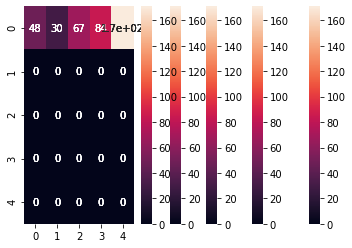

In [9]:


df_train, df_valid = model_selection.train_test_split(dfx, test_size=0.2, random_state=42, stratify=dfx.overall.values)
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

train_dataset = BERTDataset(
    review=df_train.review.values,
    target=df_train.overall.values
)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config.TRAIN_BATCH_SIZE,
    num_workers=4 # (4) in windows gotta be 0
)

valid_dataset = BERTDataset(
    review=df_valid.review.values,
    target=df_valid.overall.values
)

valid_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config.VALID_BATCH_SIZE,
    num_workers=1 # (1)
)

device = torch.device('cuda')
model = BERTBaseUncased()
model.to(device)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

num_train_steps = int(len(df_train) / config.TRAIN_BATCH_SIZE * config.EPOCHS)
optimizer = AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_train_steps

)


best_acc = 0

for epoch in range(config.EPOCHS):
    train_fn(train_data_loader, model, optimizer, device, scheduler)
    outputs, targets = eval_fn(valid_data_loader, model, device)
    outputs = np.array(outputs) >= 0.5

    acc = metrics.accuracy_score(targets, outputs) 
    print('Accuracy score = ', acc)
    confusion_matrix = metrics.confusion_matrix(outputs, targets)

    sns.heatmap(confusion_matrix, annot=True)
    if acc > best_acc:
        torch.save(model.state_dict(), config.MODEL_PATH)
        best_acc = acc

